In [9]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../../Data/income_evaluation.csv")
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.columns = list(map(lambda x: x.strip(), df.columns))

In [3]:
price_range = df[['income']].to_numpy()
price_range[price_range=="<=50K"] = 0
price_range[price_range==">50K"] = 1
df['income'] = pd.DataFrame(price_range, columns=['income'])
y_new = pd.DataFrame(price_range, columns=['income'])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [4]:
# Do a one-hot encoding of string features - otherwise the predict method will fail
for i in df.columns:
    if i in ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
        df[i] = LabelEncoder().fit_transform(df[i])
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


In [5]:
X = df.drop(columns=['income', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss'])
y = y_new
y=y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
df[['income']].value_counts()
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [7]:
clf = KNeighborsClassifier()
start_time = time.time()
clf.fit(x_train, y_train)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test)
print(f"KNN Normal Model: Predict Time: {time.time() - start_time}")
print(f"Acuracy Score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

KNN Normal Model: Fit Time: 0.151214599609375
KNN Normal Model: Predict Time: 0.2882723808288574
Acuracy Score: 0.7851988331030247
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      4945
           1       0.56      0.54      0.55      1568

    accuracy                           0.79      6513
   macro avg       0.71      0.70      0.70      6513
weighted avg       0.78      0.79      0.78      6513



In [41]:
fit_time_list = []
predict_time_list = []
number_nodes_list = []
for i in np.arange(1, 30):
    clf = KNeighborsClassifier(n_neighbors=i)
    start_time = time.time()
    clf.fit(x_train, y_train)
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    start_time = time.time()
    y_pred = clf.predict(x_test)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)


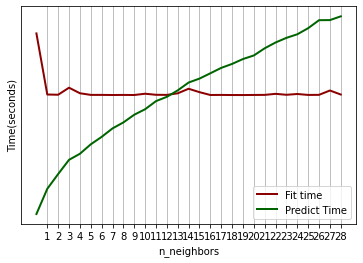

In [42]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]
lw = 2
plt.plot(normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)
plt.xlabel(r"n_neighbors")
plt.ylabel("Time(seconds)")
plt.xticks(np.arange(1, len(fit_time_list), 1.0))
plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')

In [11]:
classifiers = {}
classifiers['KNN'] = Pipeline([('scaler', StandardScaler()),
                               ('knn', KNeighborsClassifier())
                             ])
classifiers['CKNN'] = Pipeline([('scaler', StandardScaler()),
                                ('nca', NeighborhoodComponentsAnalysis()),
                                ('knn', KNeighborsClassifier())
                              ])
for name, pipeline in classifiers.items():
        print(f"Modelling classifier: {name}")
        start_time = time.time()
        p = pipeline.fit(x_train, y_train)
        print(f"{name} Normal Model Fit Time: {time.time() - start_time}")
        start_time = time.time()
        y_pred_p = p.predict(x_test)
        print(f"{name} Normal Model Predict Time: {time.time() - start_time}")
        print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")

Modelling classifier: KNN
KNN Normal Model Fit Time: 0.2222123146057129
KNN Normal Model Predict Time: 0.6454994678497314
Accuracy Score: 0.7851988331030247
Modelling classifier: CKNN
CKNN Normal Model Fit Time: 2555.178251504898
CKNN Normal Model Predict Time: 0.27855849266052246
Accuracy Score: 0.7851988331030247


In [23]:
clf_cv.estimator.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('nca', NeighborhoodComponentsAnalysis()),
  ('knn', KNeighborsClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'nca': NeighborhoodComponentsAnalysis(),
 'knn': KNeighborsClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'nca__callback': None,
 'nca__init': 'auto',
 'nca__max_iter': 50,
 'nca__n_components': None,
 'nca__random_state': None,
 'nca__tol': 1e-05,
 'nca__verbose': 0,
 'nca__warm_start': False,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [ ]:
params = {'knn__metric':['manhattan','euclidean','chebyshev'],'knn__n_neighbors':np.arange(1,51,3),'knn__weights':['uniform','distance']}
clf_cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=params, refit=True, cv=5, return_train_score=True)

start_time = time.time()
clf_cv.fit(x_train, y_train)
print(f"KNN Pipeline Model. Fit time: {time.time() - start_time}")

y_pred_cv = clf_cv.predict(x_test)

print(f"KNN Pipeline Model. Predict time: {time.time() - start_time}")
print(f"KNN Accuracy Score: {accuracy_score(y_test, y_test_cv)}")
print(f"KNN Classification Report: {classification_report(y_test, y_pred)}")
print(f"KNN Classification HP best params: {clf_cv.best_params_}")
print(f"KNN Classification HP best score: {clf_cv.best_score_}")


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None)
plot_learning_curve(clf_cv.estimator, title, X, y,  ylim=(0.5, 1.01), cv=cv, n_jobs=4)